In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seed = 42

In [3]:
from datasets import load_dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

In [4]:
train = dataset['train']

In [5]:
train_df = pd.DataFrame(train)

In [6]:
display(train_df.head())
train_df.shape

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


(16407, 3)

In [7]:
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]

In [8]:
train_df['qtype'].value_counts()

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
Name: count, dtype: int64

In [9]:
train_df.shape

(16283, 3)

In [10]:
train_df, test_df = train_test_split(train_df ,test_size = 0.3, random_state = seed)

In [11]:
display(test_df.head())
test_df.shape

,qtype,Question,Answer
12083,symptoms,What are the symptoms of Harrod Doman Keele sy...,What are the signs and symptoms of Harrod Doma...
15285,symptoms,What are the symptoms of Preaxial polydactyly ...,What are the signs and symptoms of Preaxial po...
1662,causes,What causes What I need to know about Hirschsp...,"Before birth, a childs nerve cells normally gr..."
11238,symptoms,What are the symptoms of Achondrogenesis ?,What are the signs and symptoms of Achondrogen...
13787,symptoms,What are the symptoms of Trigger thumb ?,What are the signs and symptoms of Trigger thu...


(4885, 3)

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [13]:
# Fit and transform the labels
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])

In [14]:
# Create a mapping of the original labels to the encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [15]:
# Print the mapping
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [16]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, AdamW

In [18]:
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [19]:
labels = train_df['labels'].tolist()

In [20]:
def tokenize_texts_new(texts, batch_size=8):
    input_ids_list = []
    attention_mask_list = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
    
    # Ensure consistent size for concatenation
    max_length = 512
    
    for i in range(len(input_ids_list)):
        if input_ids_list[i].size(1) != max_length:
            padding_size = max_length - input_ids_list[i].size(1)
            input_ids_list[i] = torch.nn.functional.pad(input_ids_list[i], (0, padding_size), value=tokenizer.pad_token_id)
            attention_mask_list[i] = torch.nn.functional.pad(attention_mask_list[i], (0, padding_size), value=0)
    
    # Concatenate all batches to create single tensors
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_masks = torch.cat(attention_mask_list, dim=0)
    
    return input_ids, attention_masks

In [21]:
# Tokenize the texts in your dataset
texts = train_df['Question'].tolist()
input_ids, attention_masks = tokenize_texts_new(texts)

In [22]:
display(len(input_ids))
display(len(attention_masks))
display(input_ids.shape)
display(attention_masks.shape)

11398

11398

torch.Size([11398, 512])

torch.Size([11398, 512])

In [23]:
# Convert labels to PyTorch tensor
labels = torch.tensor(labels)

In [24]:
labels.shape

torch.Size([11398])

In [25]:
# Split the dataset into train and validation sets using train_test_split
input_ids_train, input_ids_val, attention_masks_train, attention_masks_val, labels_train, labels_val = train_test_split(
    input_ids, attention_masks, labels, test_size=0.3, random_state=seed)

In [26]:
display(len(input_ids_train))
display(len(attention_masks_train))

7978

7978

In [27]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=13)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
# Freeze all layers except the last two
for name, param in model.named_parameters():
    if 'classifier' in name or 'bert.encoder.layer.11' in name or 'bert.encoder.layer.10' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [30]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = (len(input_ids_train) // 8) * 3  # Assuming 3 epochs and batch size of 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
# Training function
def train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device, batch_size=16):
    model.train()
    total_loss = 0
    for i in range(0, len(input_ids_train), batch_size):
        batch_input_ids = input_ids_train[i:i+batch_size].to(device)
        batch_attention_masks = attention_masks_train[i:i+batch_size].to(device)
        batch_labels = labels_train[i:i+batch_size].to(device)
        
        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"Batch {i}, Train loss: {loss.item():.4f}")
    return total_loss / (len(input_ids_train) // batch_size)

In [32]:
# Main training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
epochs = 3
for epoch in range(epochs):
    print('\n\nTraining Epoch', epoch)
    train_loss = train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device)
    print(f"Epoch {epoch + 1}, Train loss: {train_loss:.4f}")



Training Epoch 0
Batch 0, Train loss: 2.5189
Batch 16, Train loss: 2.6430
Batch 32, Train loss: 2.4775
Batch 48, Train loss: 2.4834
Batch 64, Train loss: 2.5231
Batch 80, Train loss: 2.4945
Batch 96, Train loss: 2.4918
Batch 112, Train loss: 2.3951
Batch 128, Train loss: 2.3839
Batch 144, Train loss: 2.5636
Batch 160, Train loss: 2.3263
Batch 176, Train loss: 2.4226
Batch 192, Train loss: 2.3890
Batch 208, Train loss: 2.3723
Batch 224, Train loss: 2.4185
Batch 240, Train loss: 2.3510
Batch 256, Train loss: 2.2588
Batch 272, Train loss: 2.3097
Batch 288, Train loss: 2.3488
Batch 304, Train loss: 2.3816
Batch 320, Train loss: 2.1112
Batch 336, Train loss: 2.2918
Batch 352, Train loss: 2.2588
Batch 368, Train loss: 2.4717
Batch 384, Train loss: 2.2617
Batch 400, Train loss: 2.2660
Batch 416, Train loss: 2.0052
Batch 432, Train loss: 1.9650
Batch 448, Train loss: 2.1337
Batch 464, Train loss: 2.3192
Batch 480, Train loss: 2.2494
Batch 496, Train loss: 2.5228
Batch 512, Train loss: 2.0789

Batch 4256, Train loss: 0.3529
Batch 4272, Train loss: 0.3889
Batch 4288, Train loss: 0.5174
Batch 4304, Train loss: 0.2829
Batch 4320, Train loss: 0.3394
Batch 4336, Train loss: 0.3499
Batch 4352, Train loss: 0.5056
Batch 4368, Train loss: 0.3486
Batch 4384, Train loss: 0.2317
Batch 4400, Train loss: 0.3776
Batch 4416, Train loss: 0.2762
Batch 4432, Train loss: 0.3972
Batch 4448, Train loss: 0.2859
Batch 4464, Train loss: 0.2811
Batch 4480, Train loss: 0.2329
Batch 4496, Train loss: 0.2956
Batch 4512, Train loss: 0.3670
Batch 4528, Train loss: 0.3800
Batch 4544, Train loss: 0.4391
Batch 4560, Train loss: 0.1945
Batch 4576, Train loss: 0.4191
Batch 4592, Train loss: 0.2815
Batch 4608, Train loss: 0.3902
Batch 4624, Train loss: 0.2304
Batch 4640, Train loss: 0.3732
Batch 4656, Train loss: 0.3858
Batch 4672, Train loss: 0.3452
Batch 4688, Train loss: 0.3324
Batch 4704, Train loss: 0.3089
Batch 4720, Train loss: 0.2853
Batch 4736, Train loss: 0.2833
Batch 4752, Train loss: 0.4144
Batch 47

Batch 512, Train loss: 0.1027
Batch 528, Train loss: 0.0925
Batch 544, Train loss: 0.0753
Batch 560, Train loss: 0.0886
Batch 576, Train loss: 0.0925
Batch 592, Train loss: 0.1366
Batch 608, Train loss: 0.1031
Batch 624, Train loss: 0.1387
Batch 640, Train loss: 0.0730
Batch 656, Train loss: 0.0898
Batch 672, Train loss: 0.1171
Batch 688, Train loss: 0.1417
Batch 704, Train loss: 0.1328
Batch 720, Train loss: 0.0879
Batch 736, Train loss: 0.1295
Batch 752, Train loss: 0.1810
Batch 768, Train loss: 0.1422
Batch 784, Train loss: 0.1169
Batch 800, Train loss: 0.1149
Batch 816, Train loss: 0.1577
Batch 832, Train loss: 0.0873
Batch 848, Train loss: 0.1025
Batch 864, Train loss: 0.1259
Batch 880, Train loss: 0.1079
Batch 896, Train loss: 0.0878
Batch 912, Train loss: 0.1084
Batch 928, Train loss: 0.0979
Batch 944, Train loss: 0.1550
Batch 960, Train loss: 0.1013
Batch 976, Train loss: 0.0770
Batch 992, Train loss: 0.1358
Batch 1008, Train loss: 0.1036
Batch 1024, Train loss: 0.1029
Batch 10

Batch 4768, Train loss: 0.0879
Batch 4784, Train loss: 0.3127
Batch 4800, Train loss: 0.0634
Batch 4816, Train loss: 0.0664
Batch 4832, Train loss: 0.1130
Batch 4848, Train loss: 0.0560
Batch 4864, Train loss: 0.0536
Batch 4880, Train loss: 0.0636
Batch 4896, Train loss: 0.0915
Batch 4912, Train loss: 0.0675
Batch 4928, Train loss: 0.0934
Batch 4944, Train loss: 0.0728
Batch 4960, Train loss: 0.0609
Batch 4976, Train loss: 0.0776
Batch 4992, Train loss: 0.0804
Batch 5008, Train loss: 0.0492
Batch 5024, Train loss: 0.0843
Batch 5040, Train loss: 0.0681
Batch 5056, Train loss: 0.0648
Batch 5072, Train loss: 0.0630
Batch 5088, Train loss: 0.0461
Batch 5104, Train loss: 0.0603
Batch 5120, Train loss: 0.0913
Batch 5136, Train loss: 0.0539
Batch 5152, Train loss: 0.0514
Batch 5168, Train loss: 0.0675
Batch 5184, Train loss: 0.0726
Batch 5200, Train loss: 0.0559
Batch 5216, Train loss: 0.0495
Batch 5232, Train loss: 0.0693
Batch 5248, Train loss: 0.0910
Batch 5264, Train loss: 0.0598
Batch 52

Batch 1040, Train loss: 0.0468
Batch 1056, Train loss: 0.0506
Batch 1072, Train loss: 0.0383
Batch 1088, Train loss: 0.0560
Batch 1104, Train loss: 0.0476
Batch 1120, Train loss: 0.0453
Batch 1136, Train loss: 0.0549
Batch 1152, Train loss: 0.0474
Batch 1168, Train loss: 0.0442
Batch 1184, Train loss: 0.0335
Batch 1200, Train loss: 0.0359
Batch 1216, Train loss: 0.0601
Batch 1232, Train loss: 0.0877
Batch 1248, Train loss: 0.0383
Batch 1264, Train loss: 0.0328
Batch 1280, Train loss: 0.0456
Batch 1296, Train loss: 0.0535
Batch 1312, Train loss: 0.0572
Batch 1328, Train loss: 0.0427
Batch 1344, Train loss: 0.0537
Batch 1360, Train loss: 0.0553
Batch 1376, Train loss: 0.0604
Batch 1392, Train loss: 0.0510
Batch 1408, Train loss: 0.0408
Batch 1424, Train loss: 0.0470
Batch 1440, Train loss: 0.0378
Batch 1456, Train loss: 0.0831
Batch 1472, Train loss: 0.0412
Batch 1488, Train loss: 0.0659
Batch 1504, Train loss: 0.0448
Batch 1520, Train loss: 0.0477
Batch 1536, Train loss: 0.0683
Batch 15

Batch 5280, Train loss: 0.0303
Batch 5296, Train loss: 0.0225
Batch 5312, Train loss: 0.0379
Batch 5328, Train loss: 0.0419
Batch 5344, Train loss: 0.0303
Batch 5360, Train loss: 0.0249
Batch 5376, Train loss: 0.0401
Batch 5392, Train loss: 0.0334
Batch 5408, Train loss: 0.0365
Batch 5424, Train loss: 0.0285
Batch 5440, Train loss: 0.0362
Batch 5456, Train loss: 0.0446
Batch 5472, Train loss: 0.0311
Batch 5488, Train loss: 0.0295
Batch 5504, Train loss: 0.0472
Batch 5520, Train loss: 0.0268
Batch 5536, Train loss: 0.0324
Batch 5552, Train loss: 0.0383
Batch 5568, Train loss: 0.0338
Batch 5584, Train loss: 0.0366
Batch 5600, Train loss: 0.0239
Batch 5616, Train loss: 0.0353
Batch 5632, Train loss: 0.0451
Batch 5648, Train loss: 0.0323
Batch 5664, Train loss: 0.0305
Batch 5680, Train loss: 0.0324
Batch 5696, Train loss: 0.0382
Batch 5712, Train loss: 0.0312
Batch 5728, Train loss: 0.0460
Batch 5744, Train loss: 0.0376
Batch 5760, Train loss: 0.0347
Batch 5776, Train loss: 0.0465
Batch 57

In [34]:
# Evaluation function
def evaluate(model, input_ids_test, attention_masks_test, labels_test, device, batch_size=8):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for i in range(0, len(input_ids_test), batch_size):
            batch_input_ids = input_ids_test[i:i+batch_size].to(device)
            batch_attention_masks = attention_masks_test[i:i+batch_size].to(device)
            batch_labels = labels_test[i:i+batch_size].to(device)
            
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits
            preds.append(logits.argmax(dim=1).cpu().numpy())
            true_labels.append(batch_labels.cpu().numpy())
    preds = np.concatenate(preds)
    true_labels = np.concatenate(true_labels)
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    precision = precision_score(true_labels, preds, average='weighted')
    recall = recall_score(true_labels, preds, average='weighted')
    return accuracy, f1, precision, recall, preds

In [36]:
# Evaluate the model
accuracy, f1, precision, recall, preds = evaluate(model, input_ids_val, attention_masks_val, labels_val, device)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9988
F1 Score: 0.9988
Precision: 0.9988
Recall: 0.9988


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 3000x3000 with 0 Axes>

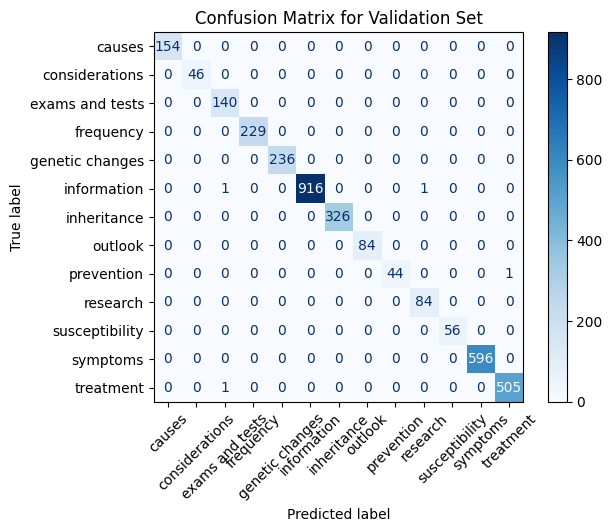

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(labels_val, preds)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Validation Set')
plt.show()

In [40]:
# Encode labels for the test set
test_df['labels'] = label_encoder.transform(test_df['qtype'])

In [41]:
# Tokenize the texts in the test set
test_texts = test_df['Question'].tolist()
test_input_ids, test_attention_masks = tokenize_texts_new(test_texts)

In [42]:
test_labels = torch.tensor(test_df['labels'].tolist())

In [43]:
# Evaluate on the test set
print("Evaluating on the test set...")
test_accuracy, test_f1, test_precision, test_recall, test_preds = evaluate(
    model, test_input_ids, test_attention_masks, test_labels, device)

Evaluating on the test set...


In [44]:
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.9998
Test F1 Score: 0.9998
Test Precision: 0.9998
Test Recall: 0.9998


<Figure size 3000x3000 with 0 Axes>

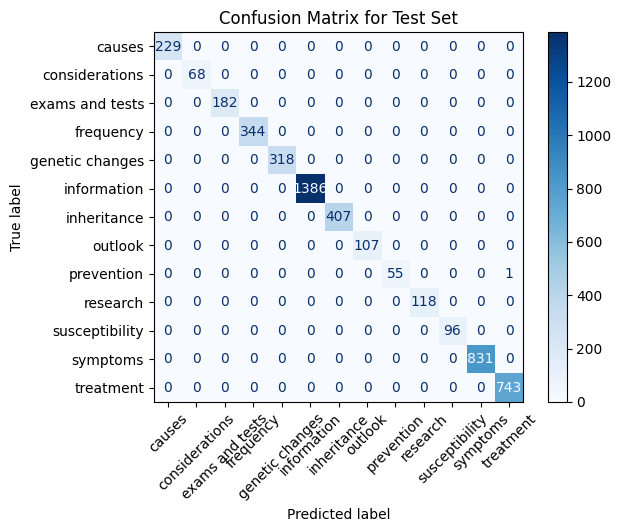

In [45]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Test Set')
plt.show()